# 3. CLASSIFICATORE SVM LINEARE CON INPUT DI WORD EMBEDDINGS

Classificatore basato su svm lineare che prende in input i word embeddings di parole italiane, più specificamente dei word embedding sviluppati per EvalIta 2018 dall'Italian NLP Lab. 

***

In [1]:
import numpy as np 
import re 
import os

### Caricamento Word Embeddings

Il file txt dei word embedding è stato ottenuto attraverso l'elaborazione di un file sqlite. Per ogni riga (la quale rappresenta una parola) all'interno del file, si crea un record in un dizionario con chiave parola e come valore il vattore che rappresenta il word embedding.

In [2]:
#funzione per il caricamento degli embedding itwac
def load_embeddings():
    embeddings_dict = dict()
    for line in open('../data/embeddings/itwac32.txt', encoding='utf-8'):
        splitted = line.strip().split('\t')
        word = splitted[0]
        embedding = splitted[1:]
        embedding = [float(val) for val in embedding]
        embeddings_dict[word] = np.asarray(embedding)
    return embeddings_dict

embeddings = load_embeddings()


In [3]:
embeddings['amico']

array([-0.02069134,  0.09119736,  0.25785723, -0.23561105, -0.28197852,
       -0.13193955, -0.13197723, -0.05229089, -0.28881341,  0.06564969,
       -0.30802506,  0.11779311, -0.03571652, -0.08748714, -0.24729131,
        0.2577146 ,  0.11925782, -0.27795964,  0.20498367,  0.08414506,
        0.08175091, -0.05181665, -0.34403449, -0.05261306,  0.08858071,
       -0.09748928,  0.12879393,  0.04387102, -0.04690454,  0.08181785,
        0.321078  ,  0.01658573])

### Normalizzazione del testo 

Le parole all'interno dei post devono essere normalizzate in questo modo:

Numeri:
- interi tra 0 e 2100 possono essere mantenuti così come sono
- i numeri interi maggiori di 2100 diventano una stringa specifica con un numero che rappresenta il numero di cifre
- se non si tratta di numeri interi, si convertono le cifre all'interno della stringa in questa sequenze @Dg

Parole:
- le parole che iniziano con una lettera maiuscola devono avere prima parola maiuscola e le altre minuscole
- le parole che iniziano con una lettera minuscola devono avere tutti i caratteri minuscolo

In [4]:
#funzione che trasforma le cifre all'interno di un token
def digit_norm(word):
    try:
        val = int(word)
    except:
        normalized = re.sub('\d', '@Dg', word)
        return normalized
    if val >= 0 and val<1200:
        return str(val)
    else:
        return f'DIGLEN_{str(len(str(val)))}'

#funzione che normalizza i token
def normalize(word):
    if "http" in word or ("." in word and "/" in word):
        return str("___URL___")
    if len(word)>26:
        return "__LONG-LONG__"
    digits = digit_norm(word)
    if digits != word:
        word = digits
    if word[0].isupper():
        word = word.capitalize()
    else:
        word = word.lower()
    return word



In [5]:
#funzione che estrae dai file conllu i token e li normalizza
def get_tokens(doc_path):
    doc_tokens = []
    skip_lines = 0
    first = False
    for line in open(doc_path, "r", encoding="utf-8"):
        splitted = line.strip().split("\t")
        if line[0].isdigit():
            if skip_lines == 0 and first == False:
                if "-" not in splitted[0]:
                    word = normalize(splitted[1])
                    pos=splitted[3]
                    token = {'word': word, 'pos': pos}
                    doc_tokens.append(token)
                else:
                    word=normalize(splitted[1])
                    skip_lines = len(splitted[0].split('-'))
                    first = True
            elif skip_lines != 0 and first == True:
                pos = splitted[3]
                token = {'word': word, 'pos': pos}
                doc_tokens.append(token)
                skip_lines-=1
                first = False
            else: 
                skip_lines-=1
    return doc_tokens

#funzione che crea il traingset o test set in base all'argomento specificato
def create_set(type):
    annotated_posts = []
    for doc in os.listdir("../data/UD_annotation"):
        if type in doc: 
            doc_path = "../data/UD_annotation/" + doc    
            doc_tokens = get_tokens(doc_path)
            annotated_posts.append(doc_tokens)
    return annotated_posts


print(get_tokens("../data/UD_annotation/training#125642756147265536#0#0#TW-SENTIPOLC.conllu"))

training_set = create_set("training")
test_set = create_set("test")

[{'word': 'Le', 'pos': 'DET'}, {'word': '5', 'pos': 'NUM'}, {'word': 'sgradevoli', 'pos': 'ADJ'}, {'word': 'realtà', 'pos': 'NOUN'}, {'word': 'di', 'pos': 'ADP'}, {'word': 'cui', 'pos': 'PRON'}, {'word': 'Berlusconi', 'pos': 'PROPN'}, {'word': 'dovrebbe', 'pos': 'AUX'}, {'word': 'rendersi', 'pos': 'VERB'}, {'word': 'personalmente', 'pos': 'ADV'}, {'word': 'conto', 'pos': 'NOUN'}, {'word': '<url>', 'pos': 'PROPN'}, {'word': 'Mario', 'pos': 'PROPN'}, {'word': 'Monti', 'pos': 'PROPN'}, {'word': 'non', 'pos': 'ADV'}, {'word': 'usa', 'pos': 'VERB'}, {'word': 'mezzi', 'pos': 'ADJ'}, {'word': 'termini', 'pos': 'NOUN'}]


In [6]:
training_set[2]

[{'word': '#la@dg', 'pos': 'NUM'},
 {'word': 'ma', 'pos': 'CCONJ'},
 {'word': 'perche', 'pos': 'ADV'},
 {'word': "'", 'pos': 'PUNCT'},
 {'word': 'Mario', 'pos': 'PROPN'},
 {'word': 'Monti', 'pos': 'PROPN'},
 {'word': 'non', 'pos': 'ADV'},
 {'word': 'fa', 'pos': 'VERB'},
 {'word': 'il', 'pos': 'DET'},
 {'word': 'premier', 'pos': 'NOUN'},
 {'word': '?', 'pos': 'PUNCT'},
 {'word': 'Che', 'pos': 'DET'},
 {'word': 'persona', 'pos': 'NOUN'},
 {'word': 'competente', 'pos': 'ADJ'},
 {'word': 'e', 'pos': 'CCONJ'},
 {'word': 'per', 'pos': 'ADP'},
 {'word': 'bene', 'pos': 'ADV'},
 {'word': '!', 'pos': 'PUNCT'}]

### Estrazione Features

Per fare in modo di avere un vettore di features per ogni sample del nostro dataset, per ogni post vanno estratti gli embedding e aggregati secondo una delle seguenti strategie:
- Somma 
- Media 
- Prodotto

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
def post_embeddings_sum(post_emb):
    return np.sum(post_emb, axis=0)

def post_embeddings_mean(post_emb):
    embeddings_sum = post_embeddings_sum(post_emb)
    return np.divide(embeddings_sum, len(post_emb))

def post_embeddings_prod(post_emb):
    return np.prod(post_emb, axis=0)

In [9]:
#funzione che restituisce gli embedding all'interno di un post e infine li aggrega secondo la strategia definita
def get_post_embeddings(post, aggr, consider_pos=[]):
    post_emb = []
    for token in post:
        word = token['word']
        pos = token['pos']
        if consider_pos == []: 
            if word in embeddings:
                single_embedding = embeddings[word]
                post_emb.append(single_embedding)
        else:
            if word in embeddings and pos in consider_pos:
                single_embedding = embeddings[word]
                post_emb.append(single_embedding)
    if len(post_emb)==0:
        post_emb = [np.zeros(32)]
    if aggr=="sum":
        return post_embeddings_sum(post_emb)
    if aggr=="mean":
        return post_embeddings_mean(post_emb)
    if aggr=="prod":
        return post_embeddings_prod(post_emb)

#funzione che estrae gli embeddings e li aggrega separatamente per part of speech; infine i tre array vengono concatenati
def get_post_embeddings_sep(post, aggr, pos_to_consider):
    all_embs = []
    for pos in pos_to_consider:
        pos_embs = []
        for token in post:
            word = token['word'] 
            if token['pos'] == pos and word in embeddings:
                pos_embs.append(embeddings[word])
        if len(pos_embs) == 0:
            pos_embs = [np.zeros(32)]
        if aggr=="sum":   
            pos_aggr = post_embeddings_sum(pos_embs)
        if aggr=="mean":
            pos_aggr = post_embeddings_mean(pos_embs)
        if aggr=="prod":   
            pos_aggr = post_embeddings_prod(pos_embs)
        all_embs.append(pos_aggr)
    all_pos_embs = np.concatenate(all_embs)
    return all_pos_embs


#print(f'Media: {post_embeddings_mean(sample)}')
#print(f'Somma: {post_embeddings_sum(sample)}')
#print(f'Prodotto: {post_embeddings_prod(sample)}')

In [10]:
sample = get_post_embeddings(training_set[0], "sum")
print(f'Features prendendo in considerazione tutte le pos: \n{sample}')

Features prendendo in considerazione tutte le pos: 
[ 0.70630973  0.63592037 -1.32889915  0.69488399  0.97954186  0.49242998
  0.81090928  0.26945482  0.86591043  0.72883238  0.12078786 -0.96009408
  1.22319504 -0.00722711  0.38346463 -0.49809163  0.90218449  0.43854262
  1.10390444 -1.22251498  1.2640001   0.58526576 -2.26762946  1.28747057
  0.96093598 -0.25486191  0.97472124 -0.47080601 -1.19037909 -0.52221277
 -0.02316337 -0.47344547]


In [11]:
sample = get_post_embeddings(training_set[0], "sum", ['ADJ', 'VERB', 'NOUN'])
print(f'Features prendendo in considerazione le pos aggettivo, verbo e sostantivo: \n{sample}')

Features prendendo in considerazione le pos aggettivo, verbo e sostantivo: 
[ 0.7420505  -0.21146497 -0.75577984  0.58708336  0.78234449 -0.08339422
  1.04220375 -0.29548807 -0.02251081 -0.11744096 -0.08204558 -0.31968346
  0.94269185  0.09774299  0.49471298 -0.72800942  0.4769331   0.37827756
  0.2307061  -0.97352124  1.0706808   0.49066386 -1.36544756  0.16201165
  0.34403714 -0.87449325 -0.27552854 -0.06722229 -0.60256457 -0.58115096
 -0.38340611  0.29236167]


In [12]:
sample = get_post_embeddings_sep(training_set[0], "sum", ['ADJ', 'VERB', 'NOUN'])
print(f'Features prendendo in considerazione solo pos aggettivo, verbo e sostantivo e concatenando le medie dei loro embeddings: \n{sample}')

Features prendendo in considerazione solo pos aggettivo, verbo e sostantivo e concatenando le medie dei loro embeddings: 
[ 0.33562477 -0.05448548 -0.42705861  0.01437109  0.45159502  0.00348032
  0.26449129  0.03243306 -0.08381133 -0.14544163 -0.05085387 -0.11924932
  0.38293768 -0.0571368   0.44839092 -0.33565044  0.37418649  0.02131738
  0.25892133 -0.28732456  0.60670963  0.151251   -0.54009455  0.04013886
  0.04687114 -0.11289249 -0.48268102 -0.13149872 -0.32601021  0.02917017
 -0.17283661 -0.01268265  0.43814081 -0.10103156 -0.19417439  0.13527741
 -0.19628561 -0.04956499  0.22108051 -0.14000706 -0.08482647  0.04375442
  0.08646346 -0.00164628  0.11506289  0.08473135 -0.06659641  0.10320415
  0.23755038 -0.05376894  0.33137974 -0.27062881 -0.07256045  0.08457013
 -0.08995622 -0.12816061  0.32735649 -0.04310134  0.07824811  0.15233405
  0.06438236 -0.14330558  0.15729892  0.33642733 -0.03171508 -0.05594792
 -0.13454684  0.43743487  0.52703507 -0.03730955  0.55663195 -0.18791406
  

In [15]:
info_description="Tutti PoS considerati, embeddings aggregati con somma"

def get_features(dataset):
    all_features = []
    for post in dataset:
        post_embeddings = get_post_embeddings(post, "sum")
        all_features.append(post_embeddings)
    return all_features

    

In [16]:
tr_features = get_features(training_set)
ts_features = get_features(test_set)

In [17]:
scaler = MinMaxScaler()
tr_features = scaler.fit_transform(tr_features)
ts_features = scaler.transform(ts_features)

In [18]:
#funzione che estrae le labels dal nome del file
def create_labels(type):
    labels = []
    for doc in os.listdir("../data/UD_annotation"):
        if type in doc: 
            splitted = doc.split("#")
            irony = splitted[2]
            labels.append(irony)
    return labels

tr_labels = create_labels("training")
ts_labels = create_labels("test")

### Validation con K-Fold

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
import numpy as np


In [20]:
splitter = KFold(n_splits=5, random_state=42, shuffle=True)
folds = list(splitter.split(tr_features))
tr_labels = np.asarray(tr_labels)
i=1
real_lbls = []
predicted = []
all_acc = []
all_dummy_acc = []

for fold in folds:
    print(f'-------------------------Fold n.{i} just started!-------------------------')
    #si creano i set per ogni fold, training e test
    train_index = fold[0]
    test_index = fold[1]
    #train set
    x_train = tr_features[train_index]
    y_train = tr_labels[train_index]
    #test set
    x_test = tr_features[test_index]
    y_test = tr_labels[test_index]
    #inizio del training
    svc = LinearSVC(dual=False)
    svc.fit(x_train, y_train)
    #predictions
    pred = svc.predict(x_test)
    acc = accuracy_score(y_test, pred)
    #usiamo un Dummy Classifier come Baseline
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(x_train, y_train)
    dummy_acc = dummy.score(x_test, y_test)
    real_lbls+=y_test.tolist()
    predicted+=pred.tolist()
    all_acc.append(acc)
    all_dummy_acc.append(dummy_acc)
    print(f"Accuracy del modello: {acc}\nAccuracy della baseline: {dummy_acc}")
    i+=1

def avg(x):
    return sum(x)/len(x)

'''
with open('results_3.txt', 'a') as file:
    file.write(f'\n{info_description}\n')
    for i in range(len(all_acc)):
        file.write(f'Risultati Fold {i+1} -->  Accuracy modello: {all_acc[i]} | Accuracy baseline: {all_dummy_acc[i]}  \n')
    file.write(f'Media: {avg(all_acc)}')
'''

-------------------------Fold n.1 just started!-------------------------
---> test: 
Accuracy del modello: 0.6520100502512562
Accuracy della baseline: 0.5062814070351759
-------------------------Fold n.2 just started!-------------------------
---> test: 
Accuracy del modello: 0.6746231155778895
Accuracy della baseline: 0.45226130653266333
-------------------------Fold n.3 just started!-------------------------
---> test: 
Accuracy del modello: 0.690566037735849
Accuracy della baseline: 0.5031446540880503
-------------------------Fold n.4 just started!-------------------------
---> test: 
Accuracy del modello: 0.660377358490566
Accuracy della baseline: 0.47924528301886793
-------------------------Fold n.5 just started!-------------------------
---> test: 
Accuracy del modello: 0.6754716981132075
Accuracy della baseline: 0.5069182389937107


"\nwith open('results_3.txt', 'a') as file:\n    file.write(f'\n{info_description}\n')\n    for i in range(len(all_acc)):\n        file.write(f'Risultati Fold {i+1} -->  Accuracy modello: {all_acc[i]} | Accuracy baseline: {all_dummy_acc[i]}  \n')\n    file.write(f'Media: {avg(all_acc)}')\n"

### Test

Si testa il modello allenato sul tipo di rappresntazioni che hanno ottenuto la migliore accuratezza durante la Kfold

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [22]:
test_preds = svc.predict(ts_features)
print(classification_report(ts_labels, test_preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.66      0.62      0.64       437
           1       0.64      0.68      0.66       435

    accuracy                           0.65       872
   macro avg       0.65      0.65      0.65       872
weighted avg       0.65      0.65      0.65       872



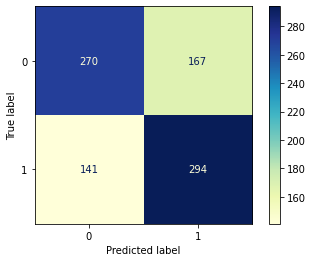

In [23]:
ConfusionMatrixDisplay.from_predictions(ts_labels, test_preds, cmap="YlGnBu")